In [1]:
from instacart_data import *
from instacart_net import *

import netpixi
from graph_tool import draw
import graph_tool_extras as gte

from graph_tool import centrality, clustering

import regression as reg

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

Carregando dados dos produtos...


In [2]:
name = 'edges_user'

In [3]:
order_products = get_order_products()

Carregando dados dos produtos dos pedidos...


In [4]:
user_orders = get_user_orders()
user = max(user_orders, key=lambda k: len(user_orders[k]))

Fazendo varredura no arquivo de pedidos...
Salvando dados dos pedidos dos usuários...


In [5]:
filtered_order_products = {}
for order in user_orders[user]:
    filtered_order_products[order] = order_products[order]

In [6]:
n_products = [ len(order) for order in filtered_order_products.values() ]
pd.Series(n_products).describe().round(2)

count    100.00
mean      14.98
std        6.10
min        4.00
25%       11.00
50%       14.00
75%       19.00
max       38.00
dtype: float64

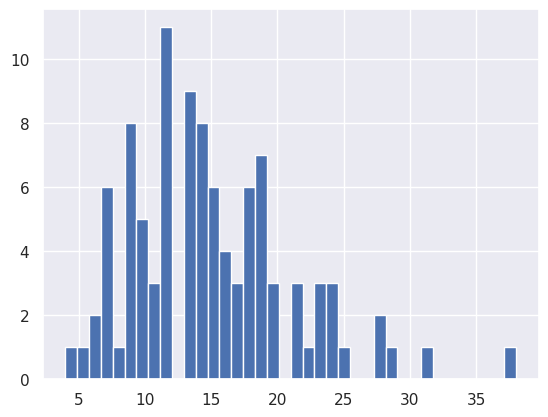

In [24]:
plt.hist(n_products, bins=np.max(n_products), edgecolor='white')
plt.show()

In [7]:
edges = gen_edges_data(filtered_order_products, name)

In [8]:
pd.Series(edges.values()).describe().round(2)

count    5949.00
mean        4.14
std         5.03
min         2.00
25%         2.00
50%         2.00
75%         4.00
max       112.00
dtype: float64

In [9]:
edges_weights = list(edges.values())
threshold = round(np.mean(edges_weights) + np.std(edges_weights), 0)
threshold

np.float64(9.0)

In [10]:
gen_edges_csv(name, edges, threshold)

536 arestas geradas com o threshold de 9.0


In [11]:
g = gen_net(name)

In [12]:
layout = draw.sfdp_layout(g)

In [13]:
gte.move(g, layout)

In [14]:
g = gte.clean(g)

In [15]:
c = centrality.closeness(g, harmonic=True)
g.add_vp('closeness', c)
b, _ = centrality.betweenness(g)
g.add_vp('betweenness', b)
d = gte.total_degree(g)
g.add_vp('degree', d)
cc = clustering.local_clustering(g)
g.add_vp('clustering', cc)

In [16]:
gte.save(g, f'{name}.net.gz')

In [25]:
r = netpixi.render(f'{name}.net.gz')

In [26]:
time.sleep(1)
r.vertex_set_key('name')
r.vertex_default(size=4, bwidth=1)
r.edge_default(width=1)

In [19]:
data = from_net_to_dataframe(g)
data

,id,aisle,department,name,purchased_once,purchased_more_than_once,number_of_users_purchased,total_purchases,PRC,_x,_y,closeness,betweenness,degree,clustering
0,23909,milk,None,2% Reduced Fat Milk,5209,3386,8595,38631,0.393950,1.120371,4.060041,0.987500,0.330566,0.9750,0.151848
1,24852,fresh fruits,None,Banana,57186,18939,76125,491291,0.248788,1.353960,2.990409,0.956250,0.247796,0.9125,0.167808
2,35547,fresh vegetables,None,Organic Baby Kale,3234,3609,6843,18977,0.527400,1.211225,4.908073,0.825000,0.061318,0.6500,0.282051
3,32030,packaged cheese,None,Extra Sharp White Cheddar,836,839,1675,4703,0.500896,0.233841,4.611439,0.818750,0.057247,0.6375,0.299608
4,4920,packaged vegetables fruits,None,Seedless Red Grapes,15150,13552,28702,86748,0.472162,0.376036,2.856399,0.793750,0.045656,0.5875,0.333025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,29941,fresh fruits,None,Red Plums,1763,2534,4297,9105,0.589714,3.324208,-5.376997,0.491667,0.000000,0.0125,0.000000
77,40229,dry pasta,None,Organic Whole Wheat Penne Rigate,1039,1817,2856,5706,0.636204,-0.667210,12.774269,0.502083,0.000000,0.0125,0.000000
78,23178,juice nectars,None,Pure Lemon Juice,743,1188,1931,4548,0.615225,-4.387919,11.277456,0.502083,0.000000,0.0125,0.000000
79,34243,fresh vegetables,None,Organic Baby Broccoli,5772,5884,11656,33143,0.504804,6.410682,11.310194,0.502083,0.000000,0.0125,0.000000


In [20]:
independente = data['clustering']
dependente = data['PRC']
controle = np.log(data['degree'])

data_hipotese = pd.DataFrame({
    'dependente': dependente, 
    'independente': independente, 
    'controle': controle
})

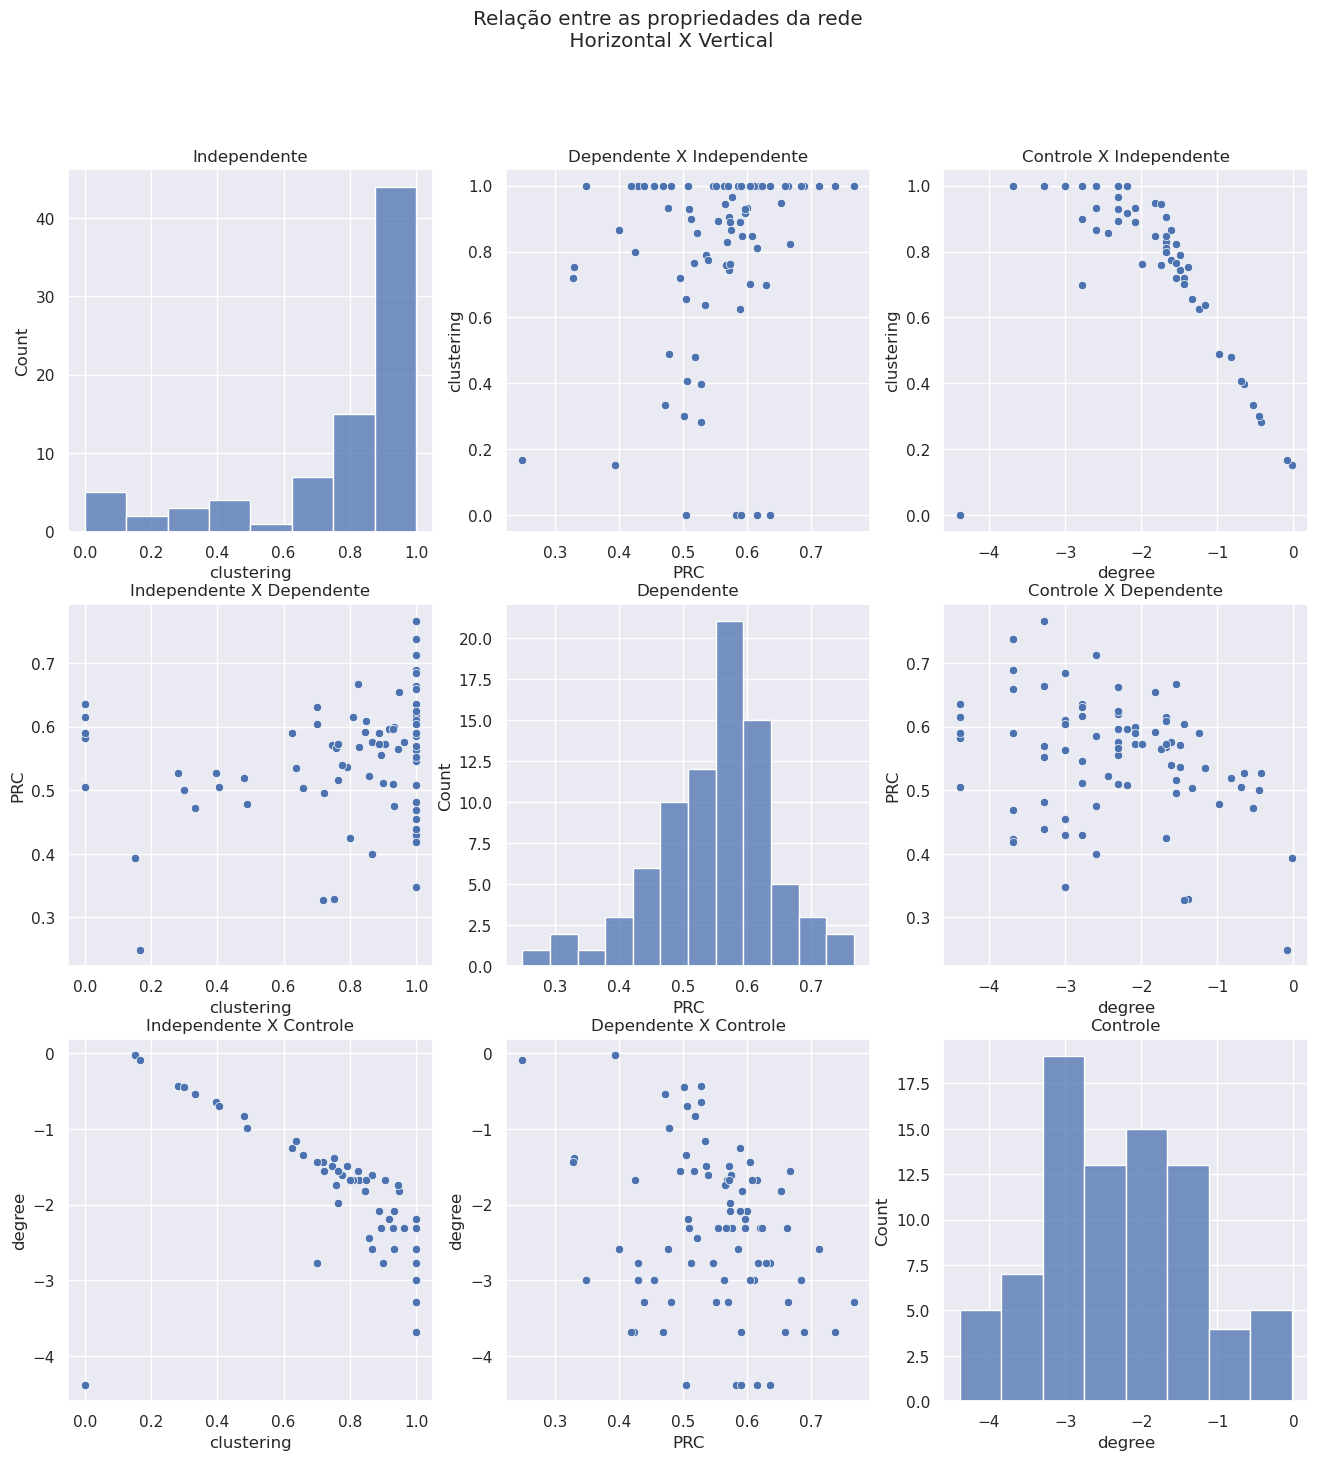

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

fig.suptitle("Relação entre as propriedades da rede\n Horizontal X Vertical")

sns.histplot(independente, ax=axes[0, 0]).set_title("Independente")
sns.scatterplot(x=dependente, y=independente, ax=axes[0, 1]).set_title("Dependente X Independente")
sns.scatterplot(x=controle, y=independente, ax=axes[0, 2]).set_title("Controle X Independente")

sns.scatterplot(x=independente, y=dependente, ax=axes[1, 0]).set_title("Independente X Dependente")
sns.histplot(dependente, ax=axes[1, 1]).set_title("Dependente")
sns.scatterplot(x=controle, y=dependente, ax=axes[1, 2]).set_title("Controle X Dependente")

sns.scatterplot(x=independente, y=controle, ax=axes[2, 0]).set_title("Independente X Controle")
sns.scatterplot(x=dependente, y=controle, ax=axes[2, 1]).set_title("Dependente X Controle")
sns.histplot(controle, ax=axes[2, 2]).set_title("Controle")

plt.show()

In [22]:
columns = ['independente', 'dependente', 'controle']
pd.DataFrame([[pearsonr(data_hipotese[j], data_hipotese[i]) for j in columns] for i in columns], columns=columns)

,independente,dependente,controle
0,1.0 (óbvio),0.2037250371 *,-0.1856915169 *
1,0.2037250371 *,1.0 (óbvio),-0.2992560956 ***
2,-0.1856915169 *,-0.2992560956 ***,1.0 (óbvio)


In [23]:
result = reg.linear(data=data_hipotese, formula='dependente ~ independente + controle') # dependente à esquerda!
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             dependente   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     4.933
Date:                Mon, 04 Nov 2024   Prob (F-statistic):            0.00961
Time:                        14:25:22   Log-Likelihood:                 81.635
No. Observations:                  81   AIC:                            -157.3
Df Residuals:                      78   BIC:                            -150.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4531      0.034     13.431      0.000       0.386       0.520
independente     0.0495      0.035      1.413      0.162      -0.020       0.119
controle        -0.0243      0.010     -2.494      0.015      -0.044      -0.005
==============================================================================
Omnibus:                        7.752   Durbin-Watson:                   2.173
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                7.679
Skew:                          -0.751   Prob(JB):                       0.0215
Kurtosis:                       3.132   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""